# Masking and extrapolation in xESMF

(contributed by [Raphael Dussin](https://github.com/raphaeldussin), based on
previous work from [jhamman](https://github.com/jhamman),
[RondeauG](https://github.com/RondeauG), [trondkr](https://github.com/trondkr)
and others)


By default, xESMF treats NaNs like regular values hence potentially resulting in
missing values bleeding into the regridded field and creating insconsistencies
in the resulting masked array. To overcome this issue, we can use explicit
masking of the source and target grids.


In [1]:
import xarray as xr
import xesmf
import numpy as np

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Preparing the grids


For this tutorial, we're using a dataset from the ROMS ocean model from this
[xarray tutorial](http://xarray.pydata.org/en/stable/examples/ROMS_ocean_model.html)


In [3]:
ds = xr.tutorial.open_dataset("ROMS_example.nc", chunks={"ocean_time": 1})

To use conservative regidding, we need the cells corners. Since they are not
provided, we are creating some using a crude approximation. **Please don't try
this at home!**


In [4]:
lon_centers = ds["lon_rho"].values
lat_centers = ds["lat_rho"].values

lon_corners = 0.25 * (
    lon_centers[:-1, :-1]
    + lon_centers[1:, :-1]
    + lon_centers[:-1, 1:]
    + lon_centers[1:, 1:]
)

lat_corners = 0.25 * (
    lat_centers[:-1, :-1]
    + lat_centers[1:, :-1]
    + lat_centers[:-1, 1:]
    + lat_centers[1:, 1:]
)

ds["lon_psi"] = xr.DataArray(data=lon_corners, dims=("eta_psi", "xi_psi"))
ds["lat_psi"] = xr.DataArray(data=lat_corners, dims=("eta_psi", "xi_psi"))

ds = ds.assign_coords({"lon_psi": ds["lon_psi"], "lat_psi": ds["lat_psi"]})

# remove exterior rho points and cut 9 extra points to make
# zeta divisible by 10 for coarsening
ds = ds.isel(
    eta_rho=slice(1, -10),
    xi_rho=slice(1, -10),
    eta_psi=slice(0, -9),
    xi_psi=slice(0, -9),
)

We also need a coarse resolution grid. We're going to build one by coarsening
the ROMS dataset. **coarsen.mean()** typically works as a nan-mean on the 10x10
blocks of the grid so the resulting land mask looks like a flooded version of
the original.


In [5]:
ds_coarse = xr.Dataset()

ds_coarse["zeta"] = xr.DataArray(
    ds["zeta"].coarsen(xi_rho=10, eta_rho=10).mean().values,
    dims=("ocean_time", "eta_rho", "xi_rho"),
)
# we want to subsample coordinates instead of coarsening them
ds_coarse["lon_rho"] = xr.DataArray(
    ds["lon_rho"].values[::10, ::10], dims=("eta_rho", "xi_rho")
)
ds_coarse["lon_psi"] = xr.DataArray(
    ds["lon_psi"].values[::10, ::10], dims=("eta_psi", "xi_psi")
)
ds_coarse["lat_rho"] = xr.DataArray(
    ds["lat_rho"].values[::10, ::10], dims=("eta_rho", "xi_rho")
)
ds_coarse["lat_psi"] = xr.DataArray(
    ds["lat_psi"].values[::10, ::10], dims=("eta_psi", "xi_psi")
)

We now have our 2 grids to test the masking in xESMF. Now let's say we want to
conservatively remap the fine ocean model output onto the coarse resolution
grid.


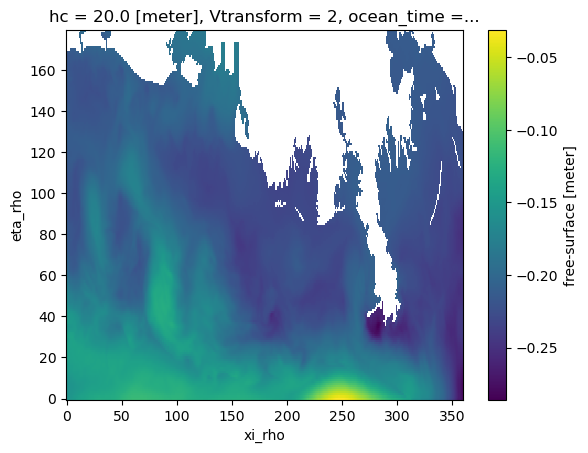

In [6]:
ds["zeta"].isel(ocean_time=0).plot()

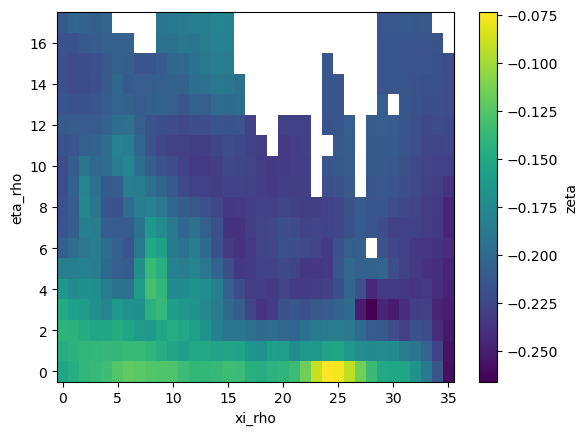

In [7]:
ds_coarse["zeta"].isel(ocean_time=0).plot()

## Regridding without a mask


As usual, xESMF expects fixed variable names for longitude/latitude in cell
centers and corners:


In [8]:
ds["lon"] = ds["lon_rho"]
ds["lat"] = ds["lat_rho"]
ds["lon_b"] = ds["lon_psi"]
ds["lat_b"] = ds["lat_psi"]

ds_coarse["lon"] = ds_coarse["lon_rho"]
ds_coarse["lat"] = ds_coarse["lat_rho"]
ds_coarse["lon_b"] = ds_coarse["lon_psi"]
ds_coarse["lat_b"] = ds_coarse["lat_psi"]

In our first test, there is no masking involved and we define the regridder the
typical way:


In [9]:
regrid_nomask = xesmf.Regridder(ds, ds_coarse, method="conservative")

In [10]:
zeta_remapped = regrid_nomask(ds["zeta"])

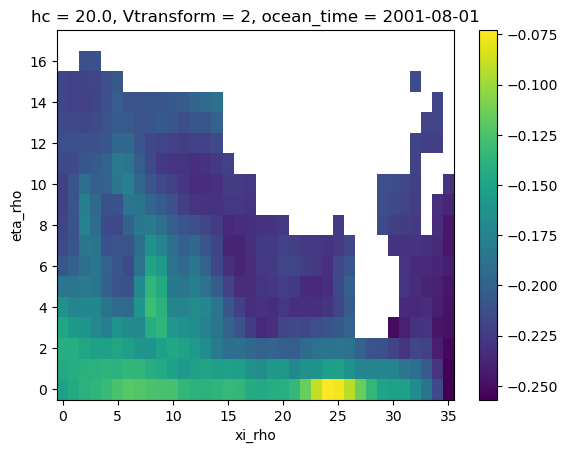

In [11]:
zeta_remapped.isel(ocean_time=0).plot()

Because of the missing values (NaNs) bleeding into the regridding, we end up
with a land mask that is much bigger than the one of the coarse grid. That's
where masking is gonna help us getting it right.


## Regridding with a mask


To use masking, we need to add a dataarray named **mask** to our datasets. Let's
define our masks on the high and coarse resolution grids from the missing values
in the zeta array:


In [12]:
ds["mask"] = xr.where(~np.isnan(ds["zeta"].isel(ocean_time=0)), 1, 0)

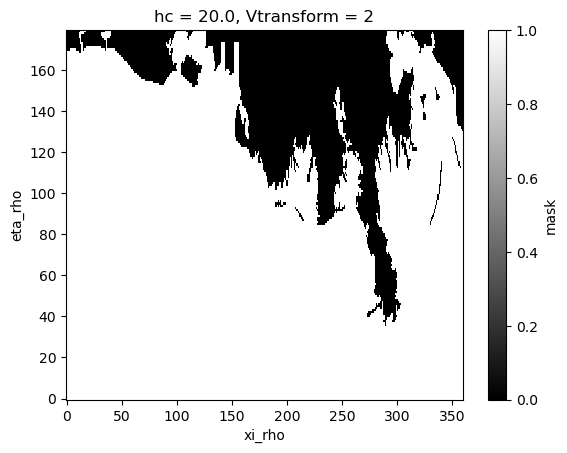

In [13]:
ds["mask"].plot(cmap="binary_r")

In [14]:
ds_coarse["mask"] = xr.where(
    ~np.isnan(ds_coarse["zeta"].isel(ocean_time=0)), 1, 0
)

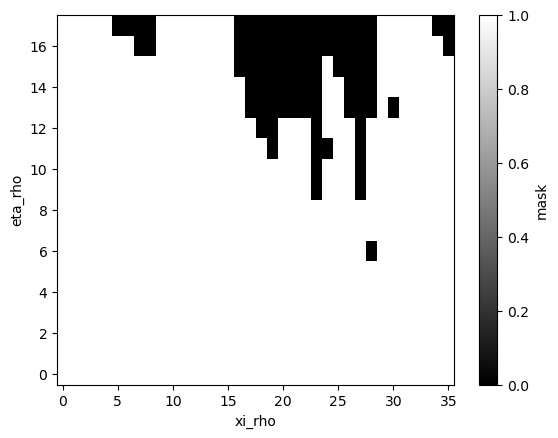

In [15]:
ds_coarse["mask"].plot(cmap="binary_r")

Now let's try to regrid again:


In [16]:
regrid_mask = xesmf.Regridder(ds, ds_coarse, method="conservative_normed")

In [17]:
zeta_remapped = regrid_mask(ds["zeta"])

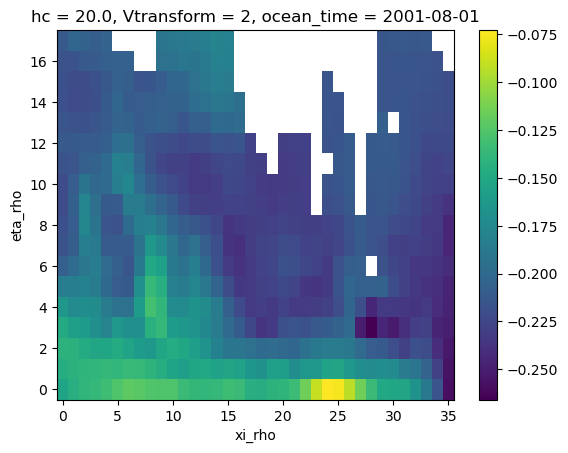

In [18]:
zeta_remapped.isel(ocean_time=0).plot()

Now we have our conservative remapping consistent with the coarse grid, yay!!


## Limitations and warnings


- mask can only be 2D (ESMF design) so regridding a 3D field requires to
  generate regridding weights for each vertical level.

- conservative method will give you a normalization by the total area of the
  target cell. Except for some specific cases, you probably want to use
  conservative_normed.

- results with other methods (e.g. bilinear) may not give masks consistent with
  the coarse grid.


### 1. Conservative (un-normed) example


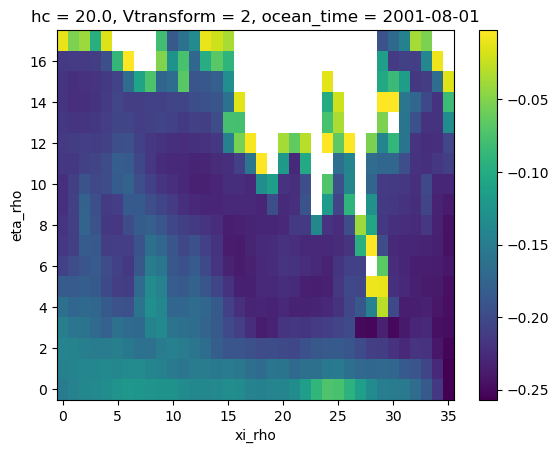

In [19]:
regrid_masked2 = xesmf.Regridder(ds, ds_coarse, method="conservative")
zeta_remapped2 = regrid_masked2(ds["zeta"])
zeta_remapped2.isel(ocean_time=0).plot()

### 2. Bilinear example


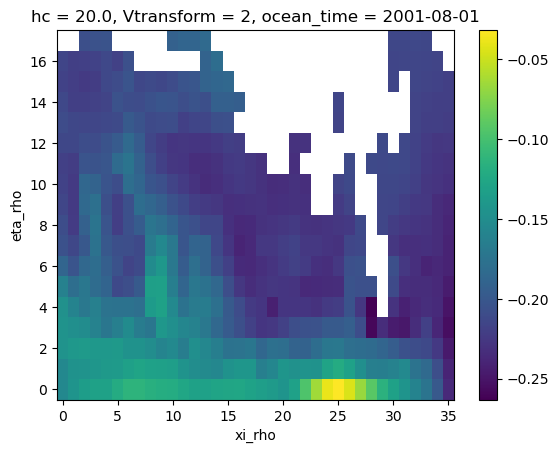

In [20]:
regrid_masked3 = xesmf.Regridder(ds, ds_coarse, method="bilinear")
zeta_remapped3 = regrid_masked3(ds["zeta"])
zeta_remapped3.isel(ocean_time=0).plot()

## Adaptive masking

The adaptive masking technique allows the reuse of weights for equal 2D fields
that are only masked differently (eg. 3D fields with different land-sea masks /
orography masks for each model layer or fields with masks varying over time). It
is applicable for the **conservative**, **patch** and **bilinear** remapping
methods and will either mask target cells or renormalize their resulting value,
depending on how big of a fraction of the overlapping source grid cells is
masked.

To use adaptive masking, the parameter **skipna** (and optionally also
**na_thres**) has to be specified when applying the remapping weights, eg.:

```python
ds_remapped = regridder(ds, [...] , skipna=True, na_thres=.25)
```

In case **skipna** is active, a given output point is set to NaN only if the
ratio of missing values exceeds the threshold level set by **na_thres**, and
else, a renormalization is conducted. For instance, when the center of a cell is
computed linearly from its four corners, one of which is missing, the output
value is set to NaN if na_thres is smaller than 0.25. Else, a renormalization is
conducted.

**na_thres** can be any value in the interval [0., 1.] (the **default
being 1.**), with `na_thres = 0.` meaning that adaptive masking will not have
any effect. With the setting `na_thres = 1.`, applying adaptive masking together
with **conservative** weights is indistinguishable from applying
**conservative_normed** weights (including a defined mask, as it has been shown
in an example above).


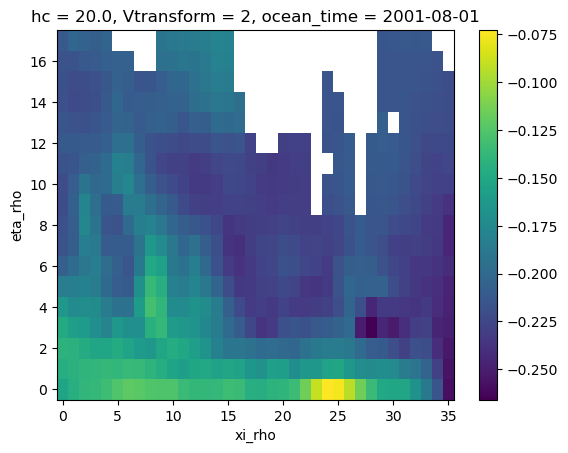

In [21]:
# Applying the 'conservative' weights without defined mask from an example above
#  with active adaptive masking and the default na_thres=1.
zeta_remapped = regrid_nomask(ds["zeta"], skipna=True)
zeta_remapped.isel(ocean_time=0).plot()

## Extrapolation


As we saw in the previous example, the bilinear interpolation was not providing
a value at all the destination points. This is where the extrapolation becomes
useful. xESMF allows to use the ESMF algorithms described in this
[section of the ESMF documentation](http://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_refdoc/node9.html#SECTION090117000000000000000).
This is a very short example and more options are available. Please refer to the
aforementioned documentation for more details.


In [22]:
regrid_extrap = xesmf.Regridder(
    ds, ds_coarse, method="bilinear", extrap_method="nearest_s2d"
)

In [23]:
zeta_remapped_extrap = regrid_extrap(ds["zeta"])

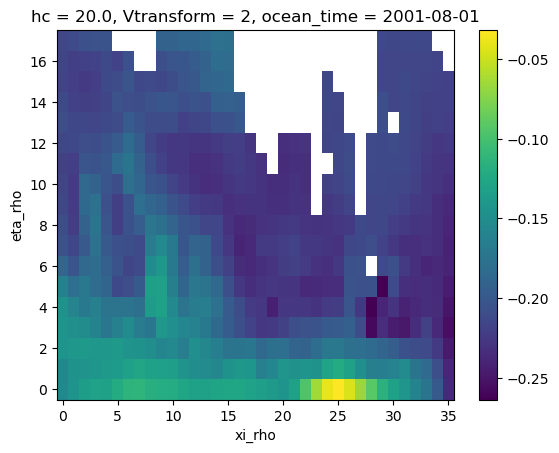

In [24]:
zeta_remapped_extrap.isel(ocean_time=0).plot()

### Avoid extrapolation when remapping to a larger domain with the `nearest_s2d` method

When remapping to a larger domain with the `nearest_s2d` method, target grid
cells outside the original source domain will get the value of the closest
source grid cell at the domain edge, independent of the selected
`extrap_method`. This can be an undesired behaviour. Please see
[Curvilinear Grid - Undesired Extrapolation](Curvilinear_grid.ipynb#Undesired-extrapolation)
for more details.
